In [1]:
%cd ..

/home/sasedov/StyleDomain/SimilarDomains


/home/sasedov/.conda/envs/StyleDomain-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import PIL

from torchvision.transforms import Resize
from itertools import combinations, product
from pathlib import Path

from core.uda_models import uda_models
from core.utils.common import mixing_noise
from core.utils.reading_weights import read_weights
from core.utils.example_utils import (
    to_im, Inferencer, 
    vstack_with_lines, 
    hstack_with_lines, 
    insert_image
)

from pprint import pprint


from draw_util import IdentityEditor, StyleEditor, morph_g_ema, weights, set_seed

/home/sasedov/.conda/envs/StyleDomain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda:0'

IMAGE_SIZE = 256
SKIP_HORIZ = 20
tr = 0.7
m_iter = 199


dom_to_editor = {
    k: StyleEditor(read_weights(p), device) for k, p in weights.items() if '.pt' not in p.name 
}

In [4]:
g = uda_models['stylegan2'](
    img_size=1024,
    latent_size=512,
    map_layers=8,
    checkpoint_path='pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt',
    device=device
).patch_layers('s_delta')

## Choose target image

In [5]:
set_seed(2)

z = [torch.randn(16, 512).to(device)]

In [6]:
# !kill 247622
# !nvidia-smi

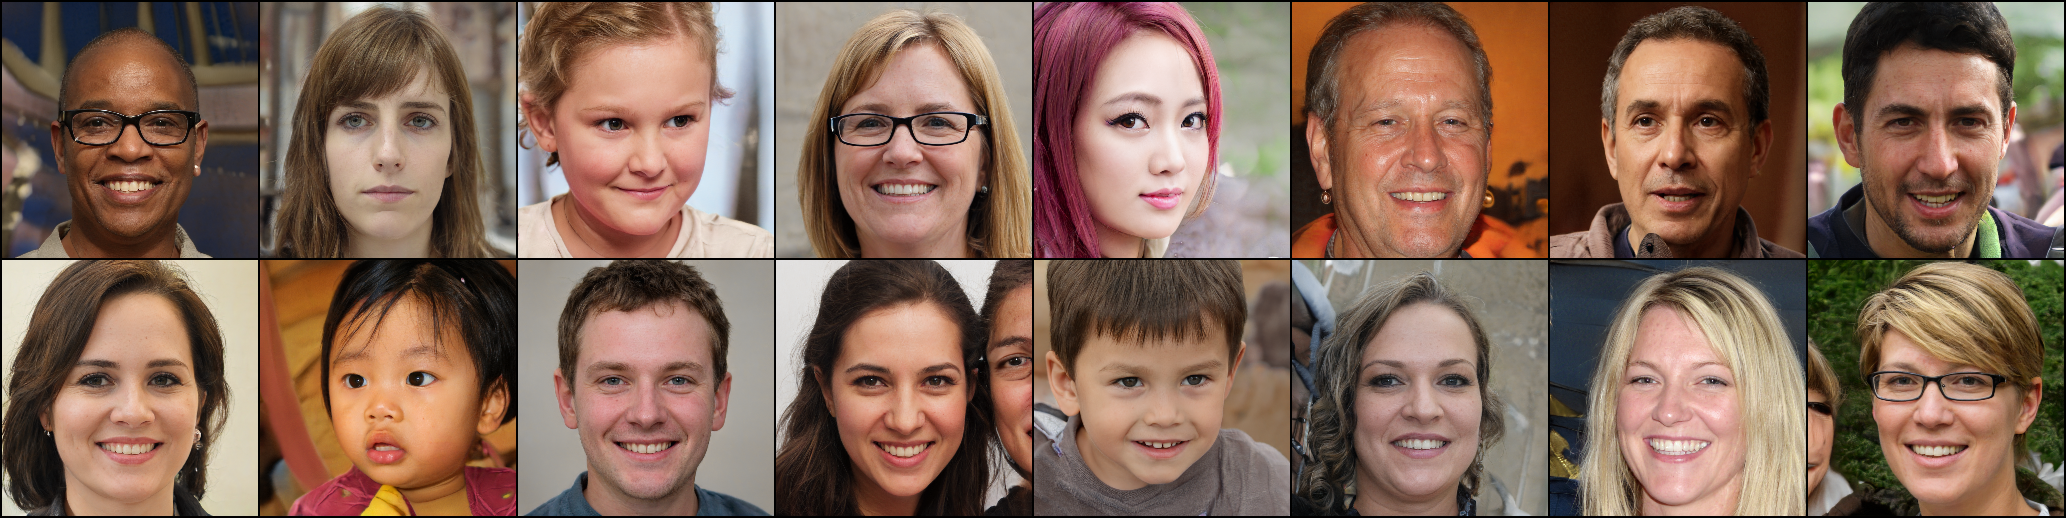

In [7]:
im, _ = g(z, truncation=tr)
to_im(Resize(256)(im))

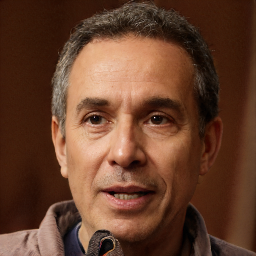

In [12]:
good_lat_idx = 6

z_single = [z[0].detach()[good_lat_idx].unsqueeze(0)]
# z.clear()
s_single = g.get_s_code(z_single, truncation=tr)
im, _ = g(s_single, is_s_code=True)
to_im(Resize(256)(im))

## Morphing

In [13]:
pprint(list(k for k, p in weights.items() if '.pt' not in p.name)) # -- possible domains

['digital_painting_jing',
 'edvard_munch_painting',
 'speed_paint',
 'the_thanos',
 'remi_castaneda_sean_connery_final',
 'tolkien_elf_indomain',
 'neanderthal_indomain',
 'modigliani_painting',
 'naufal_ilyasa_seraphine_ig_full_res',
 'sketch',
 'titan_armin',
 'hulk',
 'wesley_gardner_portraitstudy',
 'minimalist_drawing',
 'zombie_indomain',
 'mermaid',
 'maria_trepalina_img_6833_1',
 'pop_art_indomain',
 'pixar',
 'hulk_indomain',
 'arcane',
 'edvard_munch_painting_indomain',
 'rich_d_amaru_studyfinal',
 'frida_kahlo_painting',
 'hermione_granger',
 'jojo',
 'claude_monet_painting',
 'dali_painting',
 'adan',
 'neanderthal',
 'truc_huynh_hex_009v2',
 'ukiyo-e',
 'botero_indomain',
 'frida_kahlo_painting_indomain',
 'impressionist_drawing_indomain',
 'werewolf_indomain',
 'art',
 'ricardo_viana_render2',
 'impressionism_painting_indomain',
 'dali_painting_indomain',
 'botero',
 'modigliani_painting_indomain',
 'constructivism_indomain',
 'rain_artwork_dtiyschallennge',
 'impressioni

In [34]:
pow = 0.6

domain_order = ['adan', 'frida_kahlo_painting_indomain', 'cubism_painting']

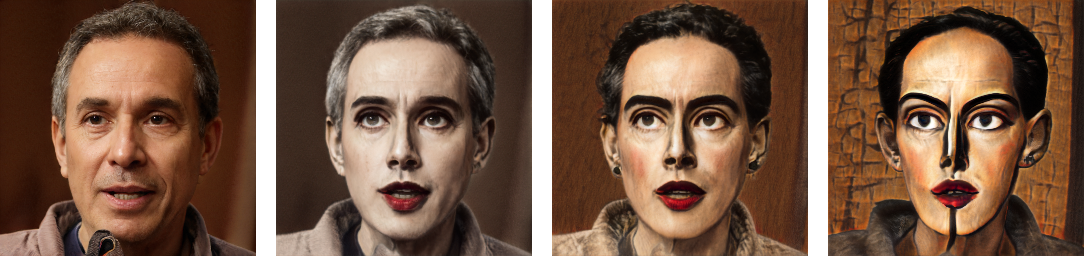

In [35]:
cur_st = [t.clone() for t in s_single]
images = [to_im(Resize(IMAGE_SIZE)(im))]

for new_domain in domain_order:
    editor = dom_to_editor[new_domain]
    cur_st = editor(cur_st, power=pow)

    cur_im, _ = g(cur_st, is_s_code=True)
    images.append(
        to_im(Resize(IMAGE_SIZE)(cur_im))
    )


final_image = hstack_with_lines(images, SKIP_HORIZ)
PIL.Image.fromarray(final_image)